In [1]:
#pip install mlflow

In [2]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

In [3]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive') #.. era para salirse de la carpeta actual y entrar en la de drive
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

# Descargamos los datos en formato parquet de Google Drive
# guardar localmente
drive.descargar_archivos_concretos('DATOS_MAX.parquet', '../drive')
# hay que pasarle la ruta a la carpeta drive desde donde lo estamos ejecutando
# y el nombre del archivo que hemos puesto en el archivos_info.txt (MLP_runs.db en nuestro ejemplo, en vez de datosEntrenamiento.parquet...)
# leer para utilizar esto ya en el modelo
data = pd.read_parquet('datos/DATOS_MAX.parquet') # 

Archivo DATOS_MAX.parquet guardado en: ./datos\DATOS_MAX.parquet


In [4]:
# Sets the sqlite db as the MLFLOW_TRACKING_URI 
#import os
#os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'

# WARNING: TO SEE THE LOCAL SERVER YOU HAVE TO CHOOSE THE CORRECT BACKEND STORE AS FOLLOWS:
# mlflow ui --port 8080 --backend-store-uri sqlite:///mlruns.db


#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [13]:
# Configurar MLflow
mlflow.set_experiment("Linear Regression Max Price")

2024/05/08 18:44:28 INFO mlflow.tracking.fluent: Experiment with name 'Linear Regression Max Price' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/chase/Documents/uni2/2%C2%BA/PD1/proyectoPDcloned/modelos/mlruns/137891499373581420', creation_time=1715186668291, experiment_id='137891499373581420', last_update_time=1715186668291, lifecycle_stage='active', name='Linear Regression Max Price', tags={}>

In [6]:

# Cargar datos
#data = pd.read_csv('./data/datos_predecir_max.csv')
# Eliminar las columnas categóricas
#columnas = ['name', 'EventStartTime', 'SalesStartTIme', 'SalesEndTime', 'nameArtist', 'VenueName',
#            'VenueCity', 'VenueState', 'Generos_combinados']
#data.drop(columnas, axis=1, inplace=True)

In [7]:
RANDOM_STATE = 83 # Fijar la semilla


In [8]:
# Dividir datos en conjuntos de entrenamiento y prueba
X = data.loc[:, data.columns != 'max_price'] # cogemos todas menos la objetivo
Y = data['max_price'] # conjunto del target
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

In [9]:
# Capturar el tiempo de inicio
start_time = time.time()

In [10]:
# Definir la validación cruzada (probar con distintas k)
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Escalar atributos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ValueError: could not convert string to float: 'Jorge Celedón'

In [ ]:
# Inicializar el modelo
lr = LinearRegression()

# Realizar cross-validation
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

# Train the model
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_pred_train)

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

Cross-Validation RMSE Scores: [5.92775640e+13 4.83947705e+14 8.26505798e+12 1.98081708e+15
 1.16181131e+02]
Mean RMSE: 506461481612106.3


2024/04/29 17:25:41 INFO mlflow.tracking.fluent: Experiment with name 'Linear Regression MinPrice' does not exist. Creating a new experiment.


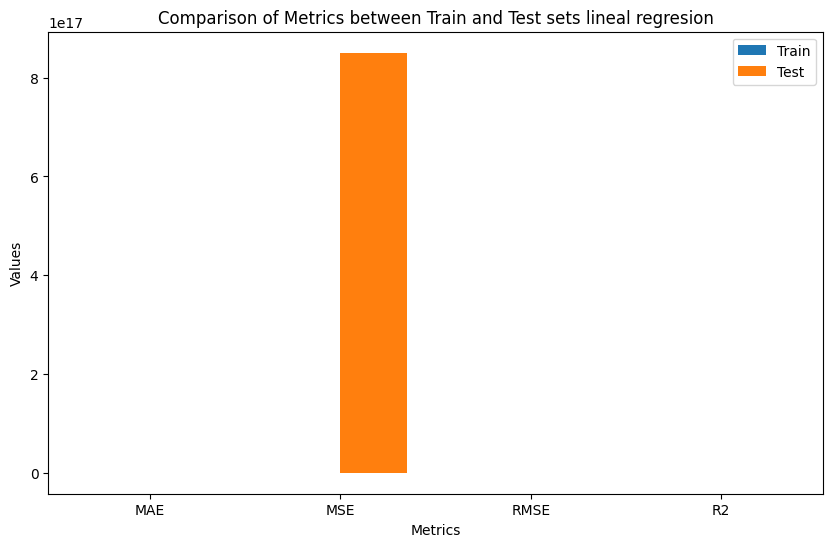

In [ ]:
# Log metrics and model with MLflow
mlflow.set_experiment("Linear Regression MinPrice")

with mlflow.start_run(run_name='0'):
    mlflow.log_metrics({
        "MAE_train": train_mae,
        "MSE_train": train_mse,
        "RMSE_train": train_rmse,
        "R2_train": train_r2,
        "MAE_test": mae,
        "MSE_test": mse,
        "RMSE_test": rmse,
        "R2_test": r2
    })

    mlflow.sklearn.log_model(lr, "linearRegression")

    # Visualize metrics
    metric_names = ['MAE', 'MSE', 'RMSE', 'R2']
    train_metrics = [train_mae, train_mse, train_rmse, train_r2]
    test_metrics = [mae, mse, rmse, r2]

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(metric_names))

    bar1 = ax.bar(index, train_metrics, bar_width, label='Train')
    bar2 = ax.bar(index + bar_width, test_metrics, bar_width, label='Test')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Comparison of Metrics between Train and Test sets lineal regresion')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metric_names)
    ax.legend()

    plt.show()